In [45]:
# Step 1: Increase the range of the inputs
pda = uniform(loc=5E-2, scale=0.1-5E-2)  # Adjusted scale
pdb = norm(loc=2E-2, scale=2E-3)  # Adjusted scale
pdc = uniform(loc=2E-2, scale=0.1-2E-2)  # Adjusted scale
pdd = norm(loc=3E-3, scale=6E-4)  # Adjusted scale
pde = uniform(loc=0.001, scale=0.1-0.001)  # Adjusted scale
pdList = [pda, pdb, pdc, pdd, pde]

# Step 2: Create risk model function
R = lambda a, b, c, d, e: a*b + b*d + a*c*e + c*d*e

# Step 3: Set up the required computational parameters
nX = 5  # Number of inputs
nS = 1000000  # Number of samples

# Step 4: Generate a matrix of random numbers
Aqtl = np.random.rand(nS, nX)
Bqtl = np.random.rand(nS, nX)

# Step 5: Inverse transform
Asamp = np.zeros((nS, nX))
Bsamp = np.zeros((nS, nX))



# Perform the inverse transform for basic events defined by the failure rates
for i in range(nX):
    Asamp[:, i] = 1 - np.exp(-pdList[i].ppf(Aqtl[:, i]))
    Bsamp[:, i] = 1 - np.exp(-pdList[i].ppf(Bqtl[:, i]))



# Step 6: Define a matrix C_i
Csamp = np.zeros((nS, nX, nX))

# Generate the matrix Csamp
for i in range(nX):
    Csamp[:, :, i] = Bsamp
    Csamp[:, i, i] = Asamp[:, i]   # Substitute ith column

# Step 7: Compute the model outputs using C_i matrices
yC = np.zeros((nS, nX))

# Run the model with matrices A, B, and C_i's
yA = R(*Asamp.T)
yB = R(*Bsamp.T)

for i in range(nX):
    yC[:, i] = R(*Csamp[:, :, i].T)



# Step 8: Compute S_i
# Preallocate the matrices for SA outputs
SiOutput = np.zeros(nX)  # First-order sensitivity index
f0 = np.mean(yA)
var_Y = np.var(yA)

for i in range(nX):
    SiOutput[i] = np.mean((yA - f0) * (yC[:, i] - np.mean(yC[:, i]))) / var_Y

# Print the first-order sensitivity indices
print(SiOutput)


[0.66833841 0.15773874 0.04564892 0.00092515 0.10118272]


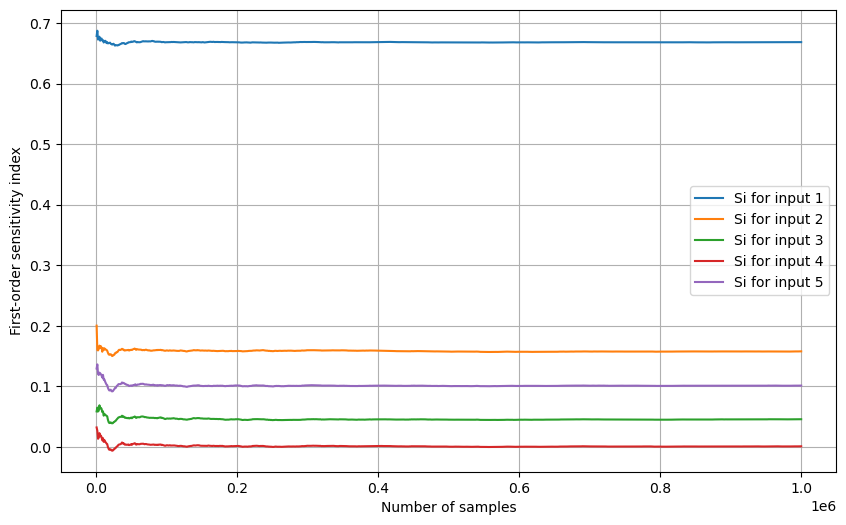

In [49]:
import matplotlib.pyplot as plt

# Define the number of iterations and the step size
n_iter = 1000
step_size = nS // n_iter

# Preallocate the array for the sensitivity indices
SiConvergence = np.zeros((n_iter, nX))

# Calculate the sensitivity indices for an increasing number of samples
for j in range(n_iter):
    n_samples = (j + 1) * step_size
    f0 = np.mean(yA[:n_samples])
    var_Y = np.var(yA[:n_samples])
    for i in range(nX):
        SiConvergence[j, i] = np.mean((yA[:n_samples] - f0) * (yC[:n_samples, i] - np.mean(yC[:n_samples, i]))) / var_Y

# Plot the convergence of the sensitivity indices
plt.figure(figsize=(10, 6))
for i in range(nX):
    plt.plot(range(step_size, nS + 1, step_size), SiConvergence[:, i], label=f'Si for input {i+1}')
plt.xlabel('Number of samples')
plt.ylabel('First-order sensitivity index')
plt.legend()
plt.grid(True)
plt.show()